Start with modeling:
Try neural nets and other machine learning algorithms

Input data:
We want to predict future volatility -> i.e. predict the VOLQ  
 - Past volatility, i.e. past values of the VOLQ 
 - Historical returns, i.e. log diff of the NASDAQ stock price (closing price?)
 - Add sentiment later -> start without 
 - Maybe volume of stock
 - US GDP growth
 - Consumer confidence index
 - US inflation 
 - US interest rates

1. step: download needed data, 2015-2020, merge datasets into one good pandas dataframe
2. Start with modeling, try recursive neural network? maybe first try basic ones like random forest, gradient boosting etc. 
3. Evaluate models using MSE
4. Forecasting: expanding window forecasting
5. Build classifier: 
    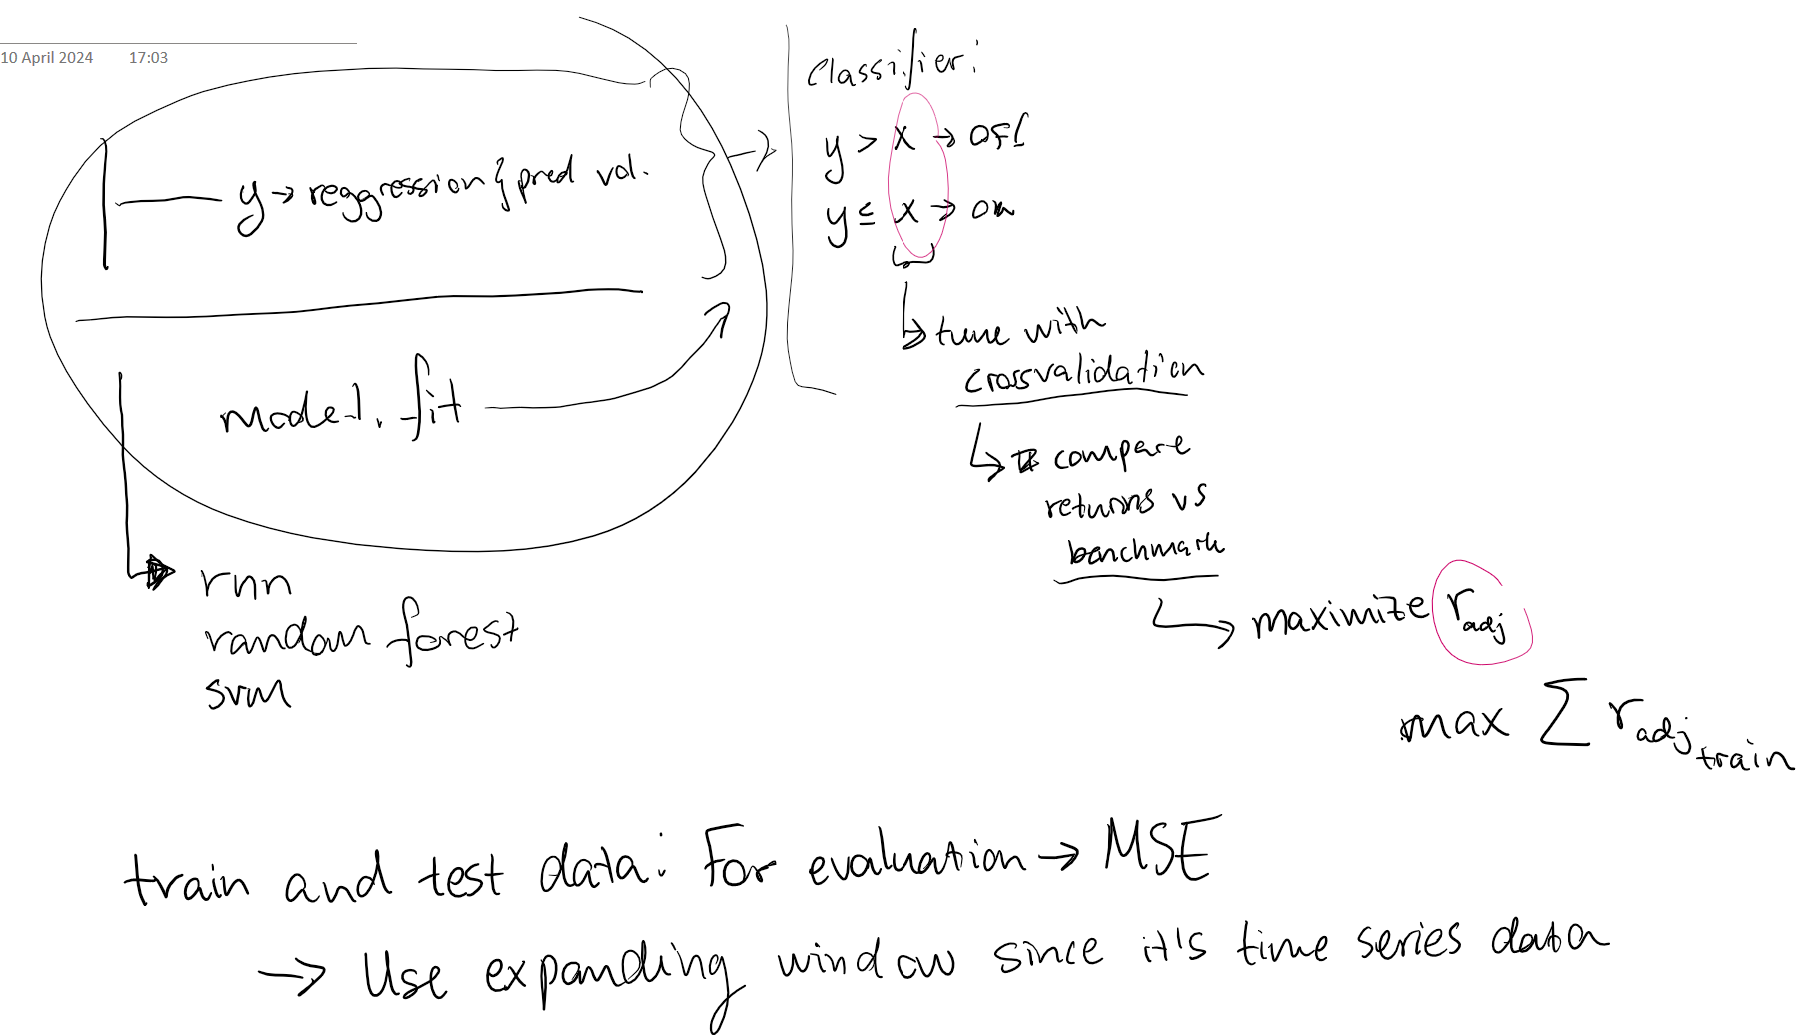
6. well see

In [3]:
#Necessary libraries:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### First step: Data

#### Checklist: Loading data:
 - [X] VOLQ
 - [X] Price
 - [X] Volume
 - [] US GDP growth -> only quarterly data so idk if its useful
 rest is monthly data, but we can just make it daily by having each day of the month have the same value
 - [X] Interest rates 
 - [X] Inflation
 - [X] Consumer confidence index

In [4]:
#Get volatility historical data:

url_volatility = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/volatility_data.csv'
volatility_df = pd.read_csv(url_volatility)
#make the date a datetime object:
volatility_df['Date'] = pd.to_datetime(volatility_df['Date'])


In [5]:
volatility_df.tail()

,Date,Price,Open,High,Low,Vol.,Change %
1253,2015-01-08,16.61,16.61,16.61,16.61,NaN,-3.43%
1254,2015-01-07,17.20,17.20,17.20,17.20,NaN,-9.71%
1255,2015-01-06,19.05,19.05,19.05,19.05,NaN,5.83%
1256,2015-01-05,18.00,18.00,18.00,18.00,NaN,8.50%
1257,2015-01-02,16.59,16.59,16.59,16.59,NaN,4.27%


In [6]:
url_nasdaq_price = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/Nasdaq100_price_data.csv'
price_df = pd.read_csv(url_nasdaq_price)
price_df['Date'] = pd.to_datetime(price_df['Date'])
price_df.head()
#this dataset includes the prices and the volume!
# we now need to calculate the returns, do this by taking the logarithm and first difference of the closing price.


,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-12-31,4294.879883,4307.009766,4233.709961,4236.279785,4236.279785,1515600000
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000


In [7]:
price_df['Log_Returns'] = np.log(price_df['Close']).diff()*100

#drop 2014-12-31 from the data:
price_df = price_df[price_df['Date'] > '2014-12-31']
price_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Log_Returns
1,2015-01-02,4258.600098,4276.709961,4206.459961,4230.240234,4230.240234,1435150000,-0.142669
2,2015-01-05,4206.549805,4210.959961,4151.850098,4160.959961,4160.959961,1794470000,-1.651298
3,2015-01-06,4174.779785,4176.259766,4090.330078,4110.830078,4110.830078,2167320000,-1.212083
4,2015-01-07,4139.850098,4169.970215,4126.390137,4160.000000,4160.000000,1957950000,1.189010
5,2015-01-08,4195.490234,4247.930176,4192.629883,4240.549805,4240.549805,2105450000,1.917786


In [8]:
# CPI data:
url_cpi = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/us_cpi_dec2014to2019.csv'
cpi_df = pd.read_csv(url_cpi)

# add monthly inflation rates (log difference like the returns)
# - not sure if log-diff is the best approach for inflation but maybe makes sense for consistency at least?

cpi_df['Log_inflation'] = np.log(cpi_df['CPIAUCSL']).diff()*100

cpi_df.head()

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

cpi_df['DATE'] = pd.to_datetime(cpi_df['DATE'])

# Filter out the first month (December 2014)
df_filtered = cpi_df[cpi_df['DATE'] > '2014-12-01']

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in df_filtered.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'CPIAUCSL': row['CPIAUCSL'],
        'Log_inflation': row['Log_inflation']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cpi_daily_data = daily_data
cpi_daily_data.head()

,DATE,CPIAUCSL,Log_inflation
0,2015-01-01,234.747,-0.639069
1,2015-01-02,234.747,-0.639069
2,2015-01-03,234.747,-0.639069
3,2015-01-04,234.747,-0.639069
4,2015-01-05,234.747,-0.639069


In [9]:
# interest rates data

url_ir = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/US_interest_rates_historical.csv'
ir_df = pd.read_csv(url_ir)

#now, the data is monthly but we want it to be daily, 
# so we want to extend it and just keep the same values for every day of each month:

#make the date a datetime object:
ir_df['DATE'] = pd.to_datetime(ir_df['DATE'])

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in ir_df.iterrows():
    # Get the first and last day of the month
    start_date = row['DATE']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'DATE': date_range,
        'interest_rate': row['INTDSRUSM193N']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)
ir_daily_data = daily_data
ir_daily_data.head()

,DATE,interest_rate
0,2015-01-01,0.75
1,2015-01-02,0.75
2,2015-01-03,0.75
3,2015-01-04,0.75
4,2015-01-05,0.75


In [10]:
#get consumer confidence data:
cci_url = 'https://raw.githubusercontent.com/inga-maria01/master_thesis/main/data/consumer_barometer_US2015to2019.csv'

cci_df = pd.read_csv(cci_url)

cci_df = pd.DataFrame({'Date': cci_df['TIME_PERIOD'],
                      'consumer_barometer': cci_df['OBS_VALUE']})

cci_df['Date'] = pd.to_datetime(cci_df['Date'])

#make it daily:

# Create an empty DataFrame for the daily data
daily_data = pd.DataFrame()

for _, row in cci_df.iterrows():
    # Get the first and last day of the month
    start_date = row['Date']
    end_date = start_date + pd.offsets.MonthEnd(1)
    
    # Generate a date range for the month
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    
    # Repeat the CPI and Log_inflation values for each day in the date range
    month_data = pd.DataFrame({
        'Date': date_range,
        'consumer_barometer': row['consumer_barometer']
    })
    
    # Append the monthly data to the daily data DataFrame
    daily_data = pd.concat([daily_data, month_data], ignore_index=True)

cci_daily_data = daily_data
cci_daily_data.head()

,Date,consumer_barometer
0,2015-01-01,0.353886
1,2015-01-02,0.353886
2,2015-01-03,0.353886
3,2015-01-04,0.353886
4,2015-01-05,0.353886


In [11]:
# merge the datasets and keep only the columns of interest:

# Assuming volatility_df, price_df, cpi_daily_data, ir_daily_data, cci_daily_data are already defined

# Step 1: Standardize Date Column Names
cpi_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)
ir_daily_data.rename(columns={'DATE': 'Date'}, inplace=True)

# Step 2: Merge DataFrames
# Merge volatility_df and price_df
merged_df = pd.merge(volatility_df[['Date', 'Price']], 
                     price_df[['Date', 'Log_Returns', 'Volume']], 
                     on='Date', 
                     how='inner')

# Merge with cpi_daily_data
merged_df = pd.merge(merged_df, 
                     cpi_daily_data[['Date', 'Log_inflation']], 
                     on='Date', 
                     how='inner')

# Merge with ir_daily_data
merged_df = pd.merge(merged_df, 
                     ir_daily_data[['Date', 'interest_rate']], 
                     on='Date', 
                     how='inner')

# Merge with cci_daily_data
merged_df = pd.merge(merged_df, 
                     cci_daily_data[['Date', 'consumer_barometer']], 
                     on='Date', 
                     how='inner')

# merged_df now contains all the desired columns with matching dates


In [12]:
#rename 'Price' to 'Volatility' and more relevant column names:
merged_df.rename(columns={'Price' : 'Volatility', 'Log_Returns' : 'stock_log_returns', 'Volume':'stock_volume', 'Log_inflation':'US_log_inflation', 'interest_rate':'US_interest_rate'}, inplace = True)
merged_df.head()


,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
0,2019-12-30,15.36,-0.700775,2051320000,0.290799,2.25,0.196109
1,2019-12-27,14.03,-0.083526,1833740000,0.290799,2.25,0.196109
2,2019-12-26,12.58,0.901718,1639960000,0.290799,2.25,0.196109
3,2019-12-24,12.36,0.040240,1014530000,0.290799,2.25,0.196109
4,2019-12-23,12.34,0.201670,2028670000,0.290799,2.25,0.196109


In [13]:
merged_df['Date'].min()

Timestamp('2015-01-02 00:00:00')

In [19]:
#now, the first date in the dataframe is 30-12-2019, and it goes back to 2015, but we would rather
# start from the oldest date and go to the newest so we have to reverse the order of the rows:

merged_df = merged_df.iloc[::-1]

merged_df.head()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
1256,2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886
1255,2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886
1254,2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886
1253,2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886
1252,2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886


In [20]:
merged_df.tail()

,Date,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
4,2019-12-23,12.34,0.201670,2028670000,0.290799,2.25,0.196109
3,2019-12-24,12.36,0.040240,1014530000,0.290799,2.25,0.196109
2,2019-12-26,12.58,0.901718,1639960000,0.290799,2.25,0.196109
1,2019-12-27,14.03,-0.083526,1833740000,0.290799,2.25,0.196109
0,2019-12-30,15.36,-0.700775,2051320000,0.290799,2.25,0.196109


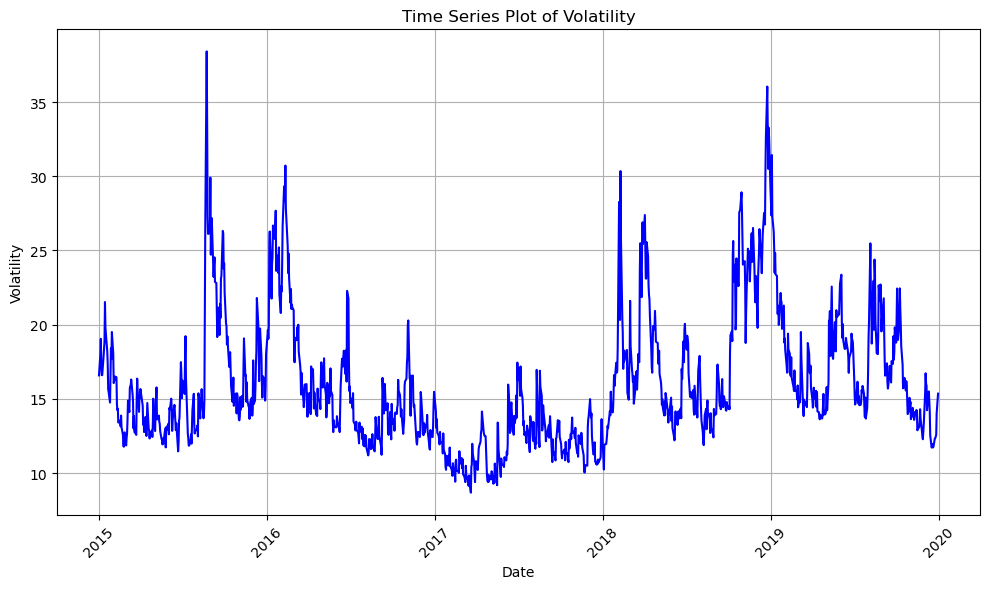

In [21]:
# Plotting the Volatility over time
plt.figure(figsize=(10, 6))  # Setting the figure size
plt.plot(merged_df['Date'], merged_df['Volatility'], linestyle='-', color='blue')  # Plotting data
plt.title('Time Series Plot of Volatility')  # Adding a title
plt.xlabel('Date')  # X-axis label
plt.ylabel('Volatility')  # Y-axis label
plt.grid(True)  # Adding a grid for better readability
plt.xticks(rotation=45)  # Rotating X-axis labels for better readability
plt.tight_layout()  # Adjusting the layout to make room for the rotated x-axis labels

# Displaying the plot
plt.show()

### Part 2: Modeling!!

Want to model the volatility, start maybe with models from AML assignments?:

In [22]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import BayesianRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [30]:
X_train, X_test, y_train, y_test = train_test_split(merged_df.loc[:, merged_df.columns != 'Date'], merged_df['Volatility'], test_size=0.2, shuffle=False)

In [31]:
X_train.tail()

,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
256,32.69,-3.200174,4571670000,0.068466,3.0,0.062721
255,36.04,-2.464733,1647440000,0.068466,3.0,0.062721
254,30.50,5.978039,2572890000,0.068466,3.0,0.062721
253,33.27,0.406815,2449110000,0.068466,3.0,0.062721
252,32.54,-0.048193,2216250000,0.068466,3.0,0.062721


In [32]:
X_test.head()

,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
251,29.11,0.708673,2109320000,0.068466,3.0,0.062721
250,27.36,0.486965,2261800000,-0.081531,3.0,-0.556296
249,31.43,-3.417989,2631550000,-0.081531,3.0,-0.556296
248,27.29,4.384862,2596150000,-0.081531,3.0,-0.556296
247,26.25,1.015894,2523450000,-0.081531,3.0,-0.556296


See that the data is split so that 2019 is the test data and 2015-2018 is the training data (except for 31-12-2018...)

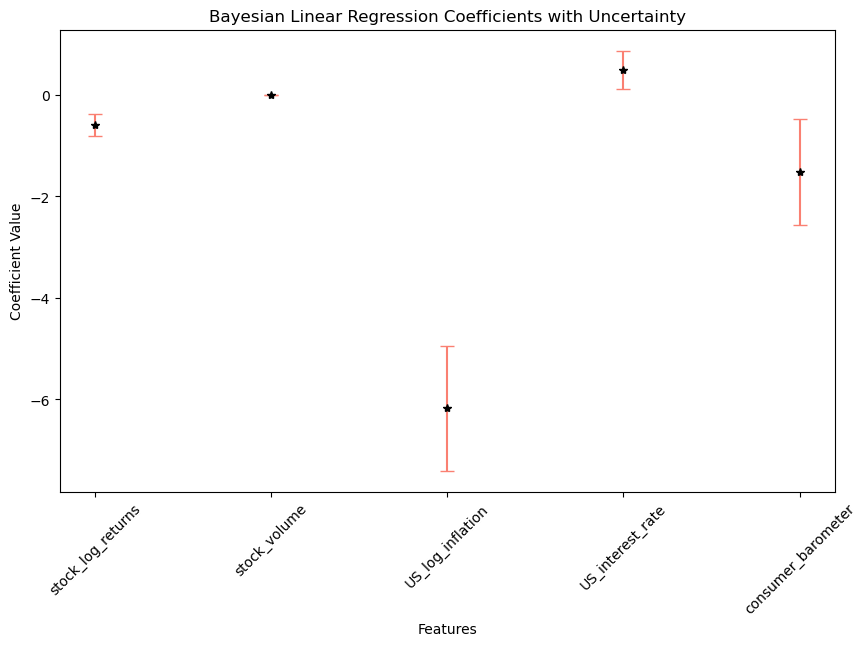

In [46]:
# Bayesian Linear Regression
bayesian_model = BayesianRidge() #stick with the default values of parameters
bayesian_model.fit(X_train.loc[:,X_train.columns != 'Volatility'], y_train)
y_pred_bayesian, y_pred_bayesian_std = bayesian_model.predict(X_test.loc[:,X_test.columns != 'Volatility'], return_std=True) #predict and return mean and std


# Extract the standard deviation of the coefficients
std_dev_coef = np.sqrt(np.diag(bayesian_model.sigma_)) #sigma contains covariacne matrix of coefficients

# Plotting the coefficient values along with standard deviation (uncertainty)
plt.figure(figsize=(10, 6))
plt.errorbar(range(len(bayesian_model.coef_)), bayesian_model.coef_,
             yerr=1.96*std_dev_coef, # 1.96 for 95% confidence interval
             fmt='*k', # make the means stars just for fun
             ecolor='salmon', # color of error bars, salmon is prettier than red
             capsize=5)
plt.xticks(range(len(bayesian_model.coef_)), X_train.columns[X_train.columns != 'Volatility'], rotation=45)
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Bayesian Linear Regression Coefficients with Uncertainty')
plt.show()

In [47]:
r2_bayes = r2_score(y_test, y_pred_bayesian)
rmse_bayes = np.sqrt(mean_squared_error(y_test, y_pred_bayesian))

print(f"R2 score: {r2_bayes}, RMSE score: {rmse_bayes}")

R2 score: 0.28032486571069226, RMSE score: 2.8634672020675676


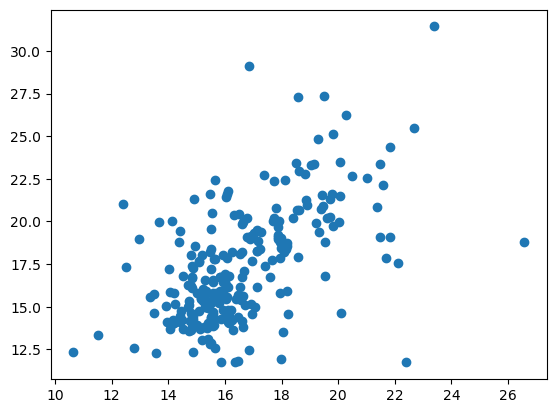

In [49]:
plt.scatter(y_pred_bayesian, y_test, )

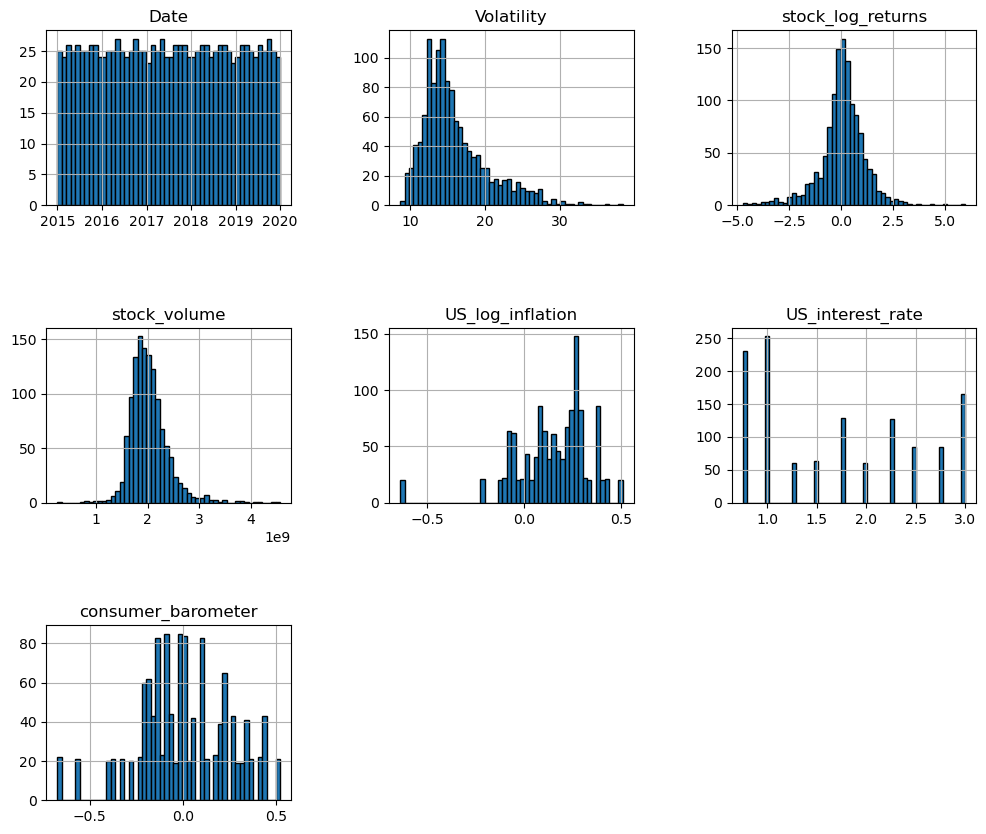

In [55]:
import seaborn as sns
merged_df.hist(figsize=(12, 10), bins=50, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [57]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.1/99.8 MB 919.0 kB/s eta 0:01:49
   ---------------------------------------- 0.7/99.8 MB 5.2 MB/s eta 0:00:20
    --------------------------------------- 2.2/99.8 MB 12.5 MB/s eta 0:00:08
   - -------------------------------------- 3.8/99.8 MB 17.3 MB/s eta 0:00:06
   -- ------------------------------------- 5.5/99.8 MB 19.5 MB/s eta 0:00:05
   -- ------------------------------------- 7.1/99.8 MB 21.7 MB/s eta 0:00:05
   --- ------------------------------------ 8.8/99.8 MB 23.5 MB/s eta 0:00:04
   ---- ----------------------------------- 10.2/99.8 MB 24.2 MB/s eta 0:00:04
   ---- ----------------------

xgboost chat code model:

In [58]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Assuming `merged_df` is your preprocessed dataset ready for modeling
X = merged_df.drop(['Date', 'Volatility'], axis=1)  # Features
y = merged_df['Volatility']  # Target variable

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initializing and training the model
model = XGBRegressor(n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

# Predicting and evaluating
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")


RMSE: 2.3068399129154518


In [60]:
r2 = r2_score(y_test, y_pred)
r2

0.7294878384680468

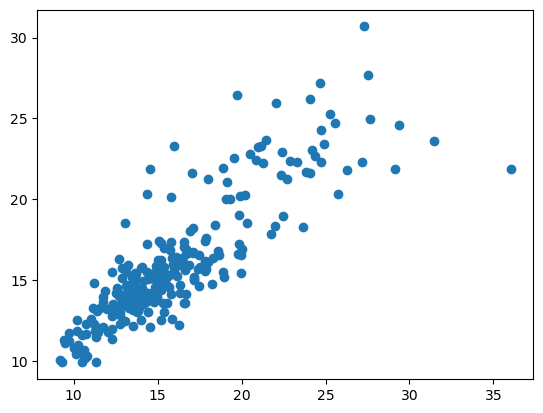

In [61]:
plt.scatter(y_test, y_pred)

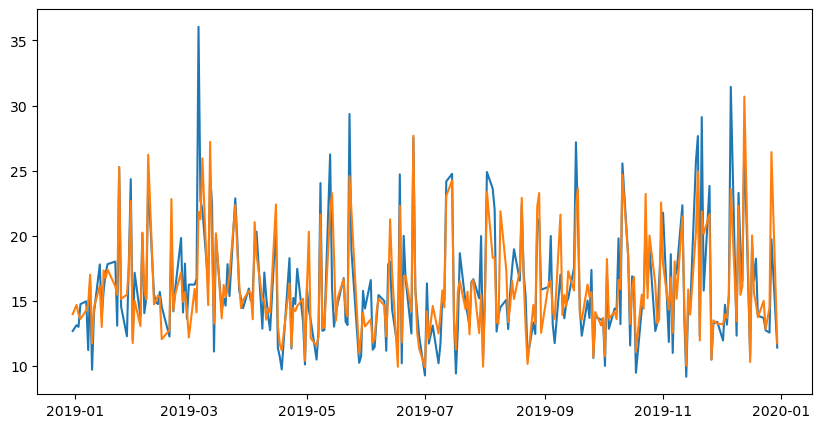

In [65]:
plt.figure(figsize=(10,5))
plt.plot(merged_df['Date'][merged_df['Date'] > '2018-12-28'], y_test)
plt.plot(merged_df['Date'][merged_df['Date'] > '2018-12-28'], y_pred)
plt.show()

In [66]:
y_train_pred = model.predict(X_train)

In [68]:
r2_score(y_train, y_train_pred)

0.9590051250626136

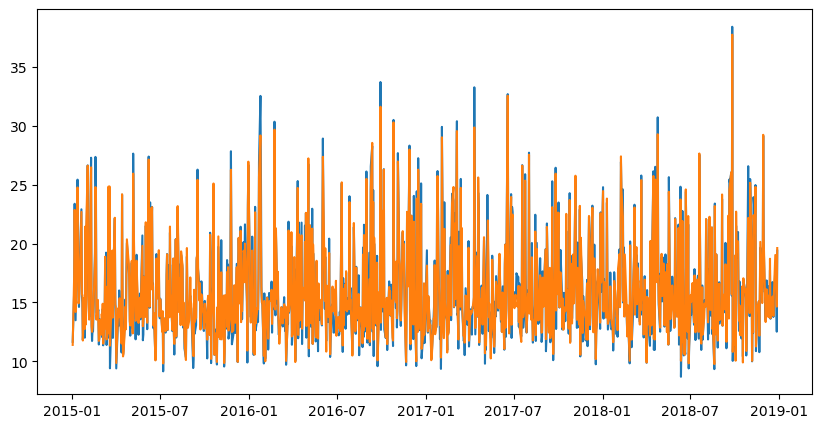

In [67]:
plt.figure(figsize=(10,5))
plt.plot(merged_df['Date'][merged_df['Date'] <= '2018-12-28'], y_train)
plt.plot(merged_df['Date'][merged_df['Date'] <= '2018-12-28'], y_train_pred)
plt.show()

#### RNN model:

using this article: https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
as inspo/help

In [70]:
#preprocessing: first set date as index:
merged_df = merged_df.set_index(['Date'])

In [71]:
merged_df.head()

,Volatility,stock_log_returns,stock_volume,US_log_inflation,US_interest_rate,consumer_barometer
Date,,,,,,
2015-01-02,16.59,-0.142669,1435150000,-0.639069,0.75,0.353886
2015-01-05,18.00,-1.651298,1794470000,-0.639069,0.75,0.353886
2015-01-06,19.05,-1.212083,2167320000,-0.639069,0.75,0.353886
2015-01-07,17.20,1.189010,1957950000,-0.639069,0.75,0.353886
2015-01-08,16.61,1.917786,2105450000,-0.639069,0.75,0.353886


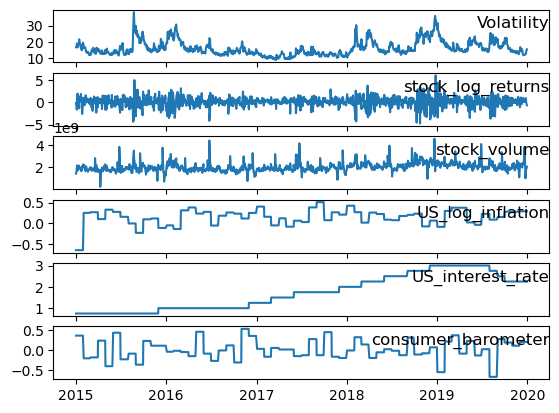

In [85]:
i = 1
# plot each column
plt.figure()
for group in merged_df.columns:
 plt.subplot(6, 1, i)
 plt.plot(merged_df[group])
 plt.title(group, y=0.5, loc='right')
 i += 1
plt.show()

In [87]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  df = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
       names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
     agg.dropna(inplace=True)
  return agg
 

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(merged_df)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[1,2,3,4,5]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)   var1(t)   var2(t)   var3(t)  var4(t)  var5(t)   var6(t)
1   0.265814  0.313257  0.288146  0.358251      0.0      0.0  0.859655
2   0.313257  0.348587  0.329127  0.444408      0.0      0.0  0.859655
3   0.348587  0.286339  0.553160  0.396028      0.0      0.0  0.859655
4   0.286339  0.266487  0.621159  0.430112      0.0      0.0  0.859655
5   0.266487  0.266151  0.382024  0.340079      0.0      0.0  0.859655


In [95]:
(len(merged_df)//5)*4

1004

In [115]:
# split into train and test sets
values = reframed.values
n_train_days = len(merged_df)//5*4 # 4/5 of the time as training data -> 80%
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(1004, 1, 6) (1004,) (252, 1, 6) (252,)


In [97]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [116]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.SimpleRNN(64, return_sequences=True))
model.add(tf.keras.layers.SimpleRNN(16, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=64, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

ValueError: Input 0 of layer "simple_rnn_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 50)

In [105]:
type(train_X)

numpy.ndarray

In [113]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

8/8 [==============================] - 0s 2ms/step
Test RMSE: 7.805


In [69]:
from tensorflow.keras import layers
from tensorflow.keras import models

Epoch 1/50
32/32 - 7s - loss: 2.2318 - val_loss: 0.1200 - 7s/epoch - 221ms/step
Epoch 2/50
32/32 - 0s - loss: 0.1475 - val_loss: 0.0767 - 166ms/epoch - 5ms/step
Epoch 3/50
32/32 - 0s - loss: 0.1080 - val_loss: 0.1120 - 166ms/epoch - 5ms/step
Epoch 4/50
32/32 - 0s - loss: 0.0711 - val_loss: 0.0741 - 165ms/epoch - 5ms/step
Epoch 5/50
32/32 - 0s - loss: 0.0955 - val_loss: 0.1094 - 167ms/epoch - 5ms/step
Epoch 6/50
32/32 - 0s - loss: 0.1046 - val_loss: 0.0715 - 172ms/epoch - 5ms/step
Epoch 7/50
32/32 - 0s - loss: 0.0848 - val_loss: 0.0824 - 170ms/epoch - 5ms/step
Epoch 8/50
32/32 - 0s - loss: 0.0937 - val_loss: 0.1092 - 247ms/epoch - 8ms/step
Epoch 9/50
32/32 - 0s - loss: 0.1125 - val_loss: 0.1598 - 168ms/epoch - 5ms/step
Epoch 10/50
32/32 - 0s - loss: 0.1341 - val_loss: 0.2011 - 170ms/epoch - 5ms/step
Epoch 11/50
32/32 - 0s - loss: 0.1473 - val_loss: 0.1907 - 169ms/epoch - 5ms/step
Epoch 12/50
32/32 - 0s - loss: 0.1464 - val_loss: 0.1435 - 171ms/epoch - 5ms/step
Epoch 13/50
32/32 - 0s - l

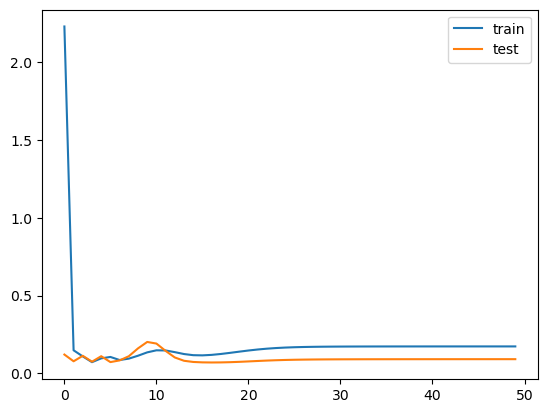

In [137]:
model_rnn = models.Sequential([
    layers.Input(shape=(train_X.shape[1], train_X.shape[2])),
    layers.Normalization(),
    #layers.SimpleRNN(64, return_sequences=True),
    #layers.SimpleRNN(16, return_sequences=False),
    layers.LSTM(64, return_sequences=True),
    layers.LSTM(32, return_sequences=True),
    layers.SimpleRNN(64, return_sequences=True),
    layers.SimpleRNN(16, return_sequences=True),
    layers.LSTM(16, return_sequences=False),
    layers.Dense(1)#, activation="relu")
])

model_rnn.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=1))
# fit network
history = model_rnn.fit(train_X, train_y, epochs=50, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()